In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import np_utils
from glob import glob

letters = []

for f in sorted(glob("/home/workspace/ASL/Train/asl_alphabet_train/*")):
    letters.append(os.path.basename(f))

letters_to_test = letters

# Build file list
root = '/home/workspace/ASL/Train/asl_alphabet_train'
train_files = []
valid_files = []
test_files = []
train_targets = []
valid_targets = []
test_targets = []

# Number of images to be used for training, validation and testing
cnt = 200

# Load training, validation and testing images
# 7% of the total data to be used for validation and the same for testing
for ind, l in enumerate(letters):
    for n in range(cnt):
        if n < cnt*0.86:
            train_targets.append(ind)
        elif n < cnt*0.93:
            valid_targets.append(ind)
        else:
            test_targets.append(ind)    
    for i, f in enumerate(glob(os.path.join(root, l, '*'))):
        if i < cnt*0.86:
            train_files.append(f)
        elif i < cnt*0.93:
            valid_files.append(f)
        elif i < cnt:
            test_files.append(f)

train_files = np.asarray(train_files)
valid_files = np.asarray(valid_files)
test_files = np.asarray(test_files)
train_targets = np.asarray(train_targets)
valid_targets = np.asarray(valid_targets)
test_targets = np.asarray(test_targets)

train_targets = np_utils.to_categorical(np.array(train_targets), 29)
valid_targets = np_utils.to_categorical(np.array(valid_targets), 29)
test_targets = np_utils.to_categorical(np.array(test_targets), 29)

print('Training data set has {} images'.format(len(train_files)))
print('Validation data set has {} images'.format(len(valid_files)))
print('Testing data set has {} images'.format(len(test_files)))

Training data set has 4988 images
Validation data set has 406 images
Testing data set has 406 images


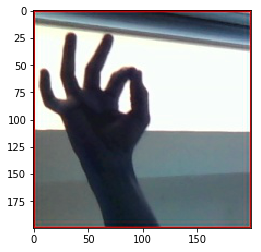

In [28]:
# Sample image
img = cv2.imread(train_files[903])

# convert RGB to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

# convert BGR image to RGB 
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [29]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile  

#Code from this box taken from ML previous examples in this machine learning nano degree

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image
    img = image.load_img(img_path)
    # convert PIL.Image.Image to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
                          
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 406/406 [00:00<00:00, 829.36it/s]


In [31]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D(data_format=None))
model.add(Dense(29, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 200, 200, 16)      208       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 100, 32)      2080      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 64)        8256      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 64)        16448     
__________

In [32]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
from keras.callbacks import ModelCheckpoint  

epochs = 10

checkpointer = ModelCheckpoint(filepath='/home/workspace/ASL/Train/weights', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

Train on 4988 samples, validate on 406 samples
Epoch 1/10
4988/4988 [==============================] - 16s 3ms/step - loss: 3.3592 - acc: 0.0369 - val_loss: 3.3298 - val_acc: 0.0542
Epoch 2/10
4988/4988 [==============================] - 15s 3ms/step - loss: 3.2357 - acc: 0.0926 - val_loss: 3.0738 - val_acc: 0.1232
Epoch 3/10
4988/4988 [==============================] - 15s 3ms/step - loss: 2.9252 - acc: 0.1606 - val_loss: 2.8418 - val_acc: 0.1749
Epoch 4/10
4988/4988 [==============================] - 15s 3ms/step - loss: 2.6275 - acc: 0.2157 - val_loss: 2.5761 - val_acc: 0.2094
Epoch 5/10
4988/4988 [==============================] - 15s 3ms/step - loss: 2.4257 - acc: 0.2512 - val_loss: 2.3596 - val_acc: 0.2389
Epoch 6/10
4988/4988 [==============================] - 15s 3ms/step - loss: 2.2687 - acc: 0.3009 - val_loss: 2.4148 - val_acc: 0.2660
Epoch 7/10
4988/4988 [==============================] - 15s 3ms/step - loss: 2.1420 - acc: 0.3274 - val_loss: 2.2021 - val_acc: 0.3202
Epoch 8/

In [34]:
model.load_weights('/home/workspace/ASL/Train/weights')

In [35]:
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 38.1773%


In [36]:
# Import and use VGG16 model

from keras.applications.vgg16 import VGG16
model = VGG16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [37]:
#from keras.applications.vgg16 import VGG16
#Show the truncated model

model = VGG16(include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [38]:
train_VGG16 = model.predict(train_tensors)
valid_VGG16 = model.predict(valid_tensors)
test_VGG16 = model.predict(test_tensors)

In [39]:
VGG16_model = Sequential()
VGG16_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=train_VGG16.shape[1:]))
VGG16_model.add(MaxPooling2D(2))
VGG16_model.add(GlobalAveragePooling2D(data_format=None))
VGG16_model.add(Dense(29, activation='softmax'))
VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 6, 6, 64)          131136    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 29)                1885      
Total params: 133,021
Trainable params: 133,021
Non-trainable params: 0
_________________________________________________________________


In [40]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [41]:
checkpointer = ModelCheckpoint(filepath='/home/workspace/ASL/Train/weights_VGG16', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=30, batch_size=10, callbacks=[checkpointer], verbose=1)

Train on 4988 samples, validate on 406 samples
Epoch 1/30
4988/4988 [==============================] - 3s 592us/step - loss: 1.8637 - acc: 0.5092 - val_loss: 0.9014 - val_acc: 0.7980
Epoch 2/30
4988/4988 [==============================] - 3s 538us/step - loss: 0.6679 - acc: 0.8340 - val_loss: 0.4516 - val_acc: 0.8818
Epoch 3/30
4988/4988 [==============================] - 3s 537us/step - loss: 0.3806 - acc: 0.9050 - val_loss: 0.3541 - val_acc: 0.9015
Epoch 4/30
4988/4988 [==============================] - 3s 541us/step - loss: 0.2582 - acc: 0.9258 - val_loss: 0.2343 - val_acc: 0.9310
Epoch 5/30
4988/4988 [==============================] - 3s 540us/step - loss: 0.1882 - acc: 0.9507 - val_loss: 0.2012 - val_acc: 0.9409
Epoch 6/30
4988/4988 [==============================] - 3s 540us/step - loss: 0.1440 - acc: 0.9619 - val_loss: 0.1537 - val_acc: 0.9507
Epoch 7/30
4988/4988 [==============================] - 3s 535us/step - loss: 0.1187 - acc: 0.9677 - val_loss: 0.1531 - val_acc: 0.9507
E

In [42]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [43]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 98.2759%


Test accuracy for A: 100.00%
Test accuracy for B: 100.00%
Test accuracy for C: 100.00%
Test accuracy for D: 100.00%
Test accuracy for E: 92.86%
Test accuracy for F: 100.00%
Test accuracy for G: 92.86%
Test accuracy for H: 100.00%
Test accuracy for I: 92.86%
Test accuracy for J: 100.00%
Test accuracy for K: 100.00%
Test accuracy for L: 100.00%
Test accuracy for M: 100.00%
Test accuracy for N: 92.86%
Test accuracy for O: 100.00%
Test accuracy for P: 100.00%
Test accuracy for Q: 100.00%
Test accuracy for R: 100.00%
Test accuracy for S: 100.00%
Test accuracy for T: 100.00%
Test accuracy for U: 100.00%
Test accuracy for V: 85.71%
Test accuracy for W: 100.00%
Test accuracy for X: 92.86%
Test accuracy for Y: 100.00%
Test accuracy for Z: 100.00%
Test accuracy for del: 100.00%
Test accuracy for nothing: 100.00%
Test accuracy for space: 100.00%


<Container object of 29 artists>

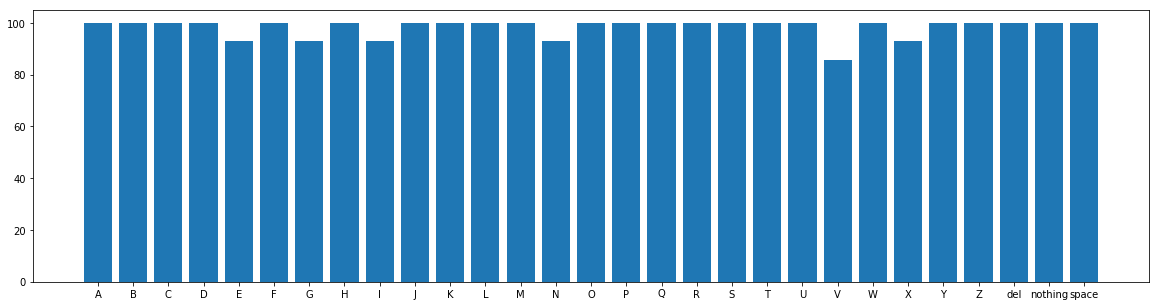

In [59]:
#Code for getting the accuracy of each category

num_categories = len(letters_to_test)

# Generate the ranges where the images for each category appear in the testing data set

l1 = []
l1.append(0)

# 14 = number of testing images for each category
for i in range(1, num_categories+1):
    l1.append(i*14)

cat_ranges = []

for i in range(num_categories):
    cat_ranges.append(range(l1[i], l1[i+1]))

l2 = []

for i in range(len(test_VGG16)):
    l2.append(i)

accuracies = []

for ind, n in enumerate(range(len(cat_ranges))):
    sub_list = list(l2[i] for i in cat_ranges[n])
    preds = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16[sub_list]]
    test_accuracy = 100*np.sum(np.array(preds)==np.argmax(test_targets[sub_list], axis=1))/14
    accuracies.append(test_accuracy)
    print('Test accuracy for {0}: %.2f%%'.format(letters_to_test[ind]) % test_accuracy)

l = []

for i in range(0, num_categories):
    l.append(num_categories)

plt.figure(figsize=(20,5))
plt.bar(list(range(0, num_categories)), accuracies, width=0.8, tick_label = letters_to_test)

In [60]:
# Fun test to translate a sentence 
from itertools import accumulate

sentance = "Congratualtions on learning ASL"
sentance = sentance.upper()

d = []

# Start taking images from index 200 of each category as that's where we stopped for training/validation/test images
for l in list(set(sentance.upper())):
    d.append((l, 200))

d=dict(d)

inputs = []

for l in sentance.upper():
    ind = d[l]
    if l == ' ':
        l = 'space'
    letters = glob(os.path.join(os.getcwd(), 'Train', 'asl_alphabet_train', l, '*'))
    inputs.append(letters[ind])
    if l == 'space':
        l = ' '
    d[l] += 1


map1 = []
map2 = []

for i, l in enumerate(letters_to_test):
    map1.append((l, i))
    if l == 'space':
        l = ' '
    map2.append((i, l))

map1 = dict(map1)
map2 = dict(map2)

test2_targets = []

for l in sentance.upper():
    if l == ' ':
        l = 'space'
    test2_targets.append(map1[l])

test2_targets = np_utils.to_categorical(np.array(test2_targets), 29)
test2_targets = np.asarray(test_targets)

In [61]:
test2_tensors = paths_to_tensor(inputs).astype('float32')/255
test2_VGG16 = model.predict(test2_tensors)


100%|██████████| 31/31 [00:00<00:00, 788.55it/s]


In [62]:
# get index of predicted dog breed for each image in test set
sentance_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test2_VGG16]

print(sentance.upper())

output = []

for i in sentance_predictions:
    output.append(map2[i])

''.join(output)

CONGRATUALTIONS ON LEARNING ASL


'CONGRATUALTIONS ON LEARNING ASL'